---

# **<font color="#6767bf"> Modelación Climática Tropical</font>**
## **<font color="#8282d6"> Atlantic Multidecadal Variability </font>**
### **<font color="#a6a6f1"> Mapas de anomalías en SPEAR por componentes (30 m)</font>**


---

In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netCDF4 

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Paqueterias
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.util import add_cyclic_point
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
import cftime
from scipy import stats
import glob

In [7]:
def mapa_MC(data, levels, ccmap, titulo, extend='both', cbarlabel='pr  [mm día$^{-1}$]', 
            limite_NS=75, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    lons, lats = data.lon, data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cs = ax.contourf(lon, lats, data, levels=levels, cmap=ccmap, extend=extend, transform=ccrs.PlateCarree())

    # Definimos la extensión del mapa
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([0, 359.1, -limite_NS, limite_NS], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo, fontsize=19)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    # agregar colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

In [8]:
def add_map_colorbar(orientation, position, label, fig, cs):
    cbar_ax = fig.add_axes(position)  
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation=orientation)
    cbar.set_label(label, fontsize=17)
    cbar.ax.tick_params(labelsize=16)

In [9]:
miembros = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
ens_rolled_list = []
ens_forced_list = []
ens_natural_list = []

In [10]:
# Abrimos el índice 
indice_ds  = xr.open_dataset('simulation_ocean_index.nc')
#indice_ds= indice_ds.sel(time=slice('1980', '2010'))
indice_suavizado = indice_ds.AMO.rolling(time=120, min_periods=60).mean()
promedio_indices = indice_suavizado.mean('ens')

In [11]:
def select_matching_time(datetime_series: pd.Series, data_array: xr.DataArray):
    if isinstance(data_array['time'].values[0], cftime.DatetimeJulian):
        xarray_time = data_array.indexes['time'].to_datetimeindex()
    else:
        xarray_time = pd.to_datetime(data_array['time'].values).normalize()
    xarray_time = data_array['time'].dt.strftime('%Y-%m')
    datetime_index = datetime_series.dt.strftime('%Y-%m')
    mask = xarray_time.isin(datetime_index)
    return data_array.where(mask, drop=True)

In [12]:
def composite_mean(da):
    climatologia = da.groupby('time.month').mean('time')
    return climatologia.mean('month')

In [13]:
for ens_id in miembros:
    # Abrimos los archivos ens
    filename = f'/home/jovyan/ModClim/SPEAR/monthly_ens0{ens_id}.nc'
    ds = xr.open_dataset(filename)
    pr = ds['precip'] * 86400
    pr['units'] = 'mm day-1'
    #pr = pr.sel(lat=pr.lat[pr.lat > 0], lon=pr.lon[pr.lon > 180])
    #pr=pr.sel(time=slice('1980', '2010'))
    pr_jjas=pr.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

    # indice AMO del miembro actual
    Ens = indice_ds.AMO.sel(ens=int(ens_id) - 1)
    amv_df = Ens.to_dataframe().reset_index()
    amv_df['rolled'] = amv_df['AMO'].rolling(window=120, min_periods=60).mean()
    amv_df['forced'] = promedio_indices.values
    amv_df['natural'] = amv_df['rolled'] - amv_df['forced']
    amv_df['Date'] = pd.to_datetime(amv_df['time'].values)
    amv_JJAS = amv_df[amv_df['Date'].dt.month.isin([6, 7, 8, 9])]

    for tipo in ['rolled', 'forced', 'natural']:
        positivos = amv_JJAS[amv_JJAS[tipo] > 0]
        negativos = amv_JJAS[amv_JJAS[tipo] < 0]

        pr_positivos = select_matching_time(positivos['Date'], pr_jjas)
        pr_negativos = select_matching_time(negativos['Date'], pr_jjas)

        promedio_total_JJAS = pr_jjas.mean(dim='time')

        anom_positivos = pr_positivos - promedio_total_JJAS
        anom_negativos = pr_negativos - promedio_total_JJAS

        anom_pos_clim = composite_mean(anom_positivos)
        anom_neg_clim = composite_mean(anom_negativos)

        anom_final = anom_pos_clim - anom_neg_clim
        anom_final.name = f'anom_{tipo}_{ens_id}'

        # Guardamos en la lista de cada componente 
        if tipo == 'rolled':
            ens_rolled_list.append(anom_final)
        elif tipo == 'forced':
            ens_forced_list.append(anom_final)
        elif tipo == 'natural':
            ens_natural_list.append(anom_final)

In [14]:
# concatenamos y se promedia entre miembros
anom_rolled_mean = xr.concat(ens_rolled_list, dim='ens').mean(dim='ens')
anom_forced_mean = xr.concat(ens_forced_list, dim='ens').mean(dim='ens')
anom_natural_mean = xr.concat(ens_natural_list, dim='ens').mean(dim='ens')

In [15]:
anom_rolled_mean['units'] = 'precip'

lons=anom_rolled_mean.lon
lats=anom_rolled_mean.lat
anom_rolled_mean

#anom_rolled_mean.to_netcdf("anom_rolled_mean_reciente_SPEAR_min.nc")

<xarray.DataArray 'anom_rolled_01' (lat: 90, lon: 104)> Size: 37kB
array([[ 0.00507968,  0.00475708,  0.00456846, ..., -0.1028826 ,
        -0.04972398, -0.00946172],
       [ 0.00383528,  0.00380693,  0.0039434 , ..., -0.1334498 ,
        -0.09859192, -0.04734503],
       [ 0.003605  ,  0.00387756,  0.00383923, ..., -0.19301432,
        -0.17125024, -0.11276834],
       ...,
       [-0.07236074, -0.10744102, -0.08147928, ...,  0.05896372,
         0.0645676 ,  0.05804243],
       [-0.06250884, -0.08841091, -0.09788842, ...,  0.03310013,
         0.03870166,  0.0380949 ],
       [-0.05763149, -0.08283904, -0.09952717, ...,  0.02022566,
         0.02579307,  0.02331761]], dtype=float32)
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U6 24B 'precip'

In [16]:
# Nombramos las variables para graficar adelante
anom_rolled_mean.name = 'anom_total_mean'
anom_forced_mean.name = 'anom_forced_mean'
anom_natural_mean.name = 'anom_natural_mean'

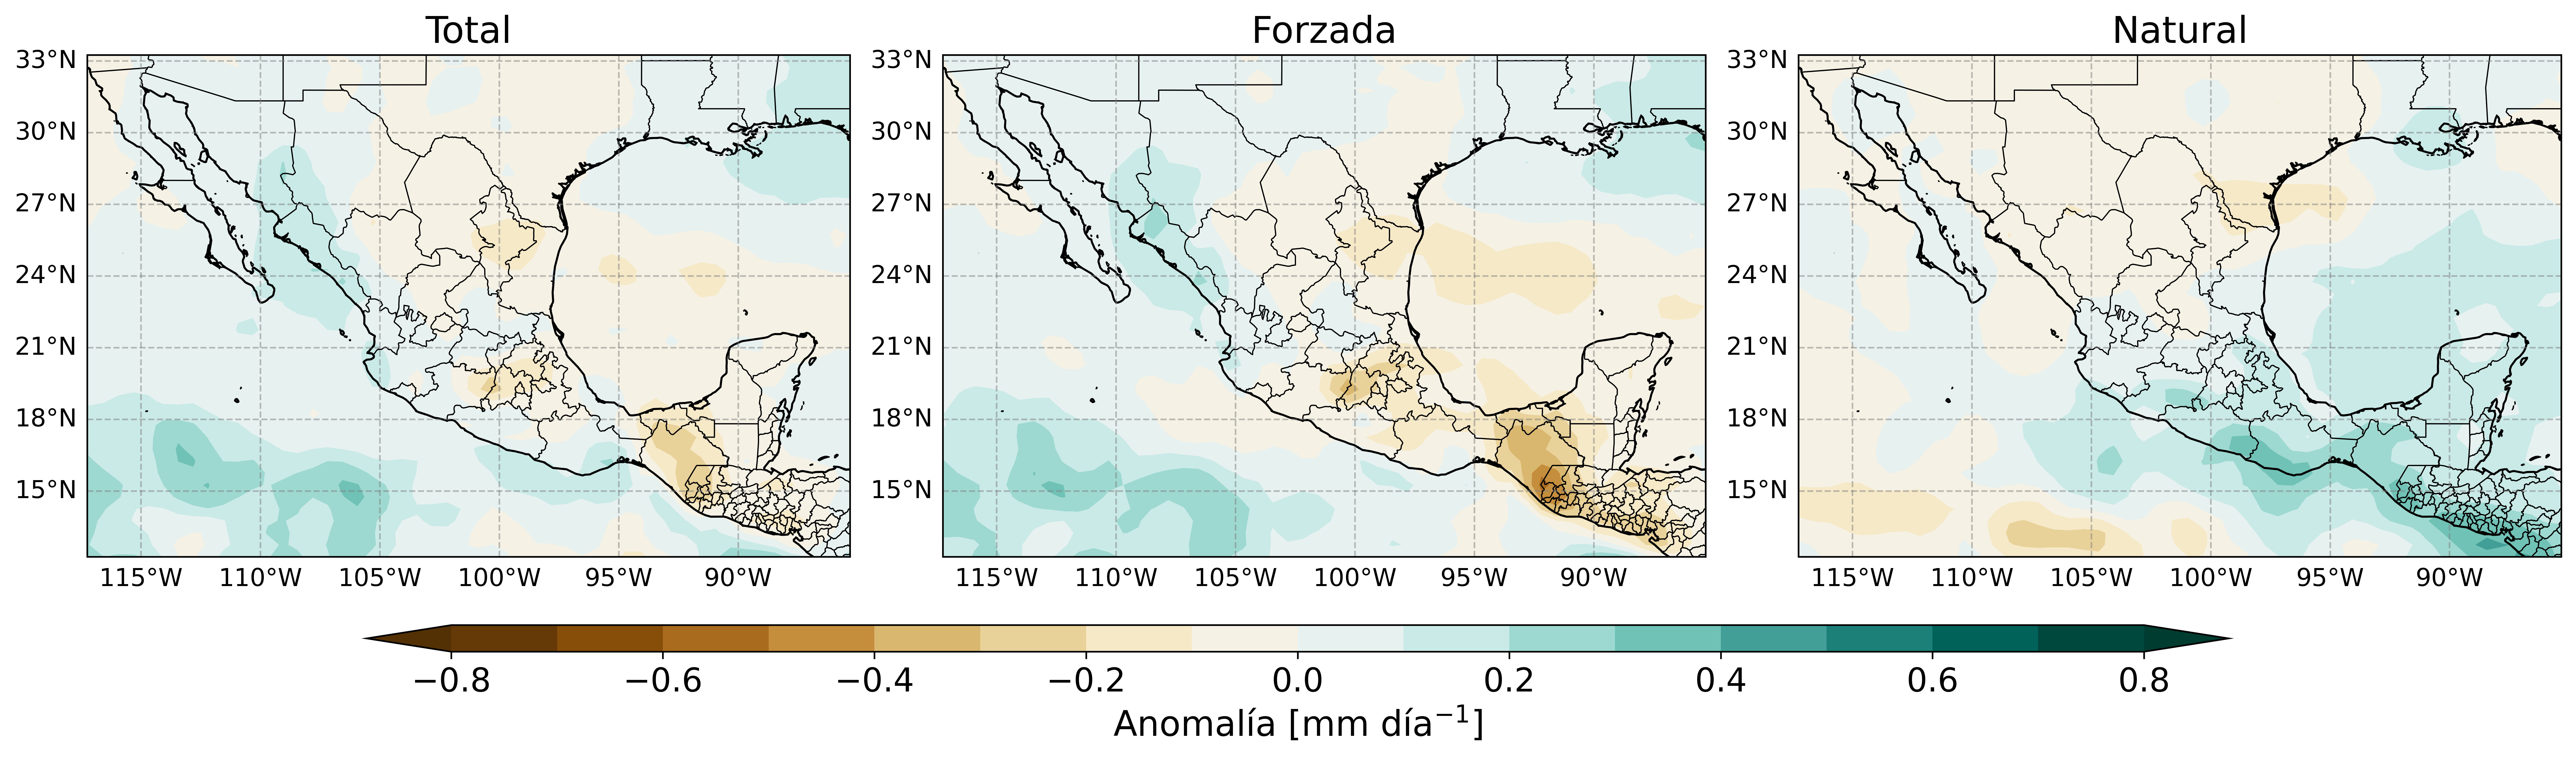

In [17]:
# Creamos diccionario con cada componente
datos = {"Total": anom_rolled_mean, "Forzada": anom_forced_mean, "Natural": anom_natural_mean}

# subplots 
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=600, subplot_kw={'projection': ccrs.PlateCarree()})
#panel_labels = ['a)', 'b)', 'c)']

levels = np.arange(-0.8, 0.81, 0.1)  # levels 

# ciclo para graficar
for i, (titulo, anom) in enumerate(datos.items()):
    ax = axs[i]
    ax.coastlines()
    
    # Contourf
    cs = ax.contourf(anom.lon, anom.lat, anom,levels=levels, cmap='BrBG', extend='both',transform=ccrs.PlateCarree())

    # Configuración
    ax.set_extent([242.75,274.68, 12.25, 33.25], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.55)
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 12}  # Tamaño de fuente para longitudes
    gl.ylabel_style = {'size': 12} 
    plt.tight_layout(pad=1.0) 
    gl.top_labels = gl.right_labels = False

    # Titulo 
    ax.set_title(titulo, fontsize=18)

  #  ax.text(0.97, 0.95, panel_labels[i], transform=ax.transAxes, fontsize=17, fontname='Liberation Serif', fontweight='bold', va='top', ha='right',
    #    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.27', linewidth=1))

# Agregamos cbar
add_map_colorbar('horizontal', [0.14, 0.11, 0.7, 0.03], 'Anomalía [mm día$^{-1}$]', fig, cs)

#plt.tight_layout()
plt.show()

In [18]:
# para ver cuales miembros coinciden convertimos la lista en un dataarray con ens
# Natural
ens_natural = xr.concat(ens_natural_list, dim='ens')
# esto para ver si el signo es positivo, negativo o 0
signo_mean_natural = np.sign(anom_natural_mean) # es el signo del promedio del ens
signo_miembros = np.sign(ens_natural) # es el signo de cada miembro

In [19]:
# vemos si el signo del miembro coincide con el del mean
coinciden_natural = signo_miembros == signo_mean_natural
# contamos las coincidencias en la dimension del ensamble
conteo_natural = coinciden_natural.sum(dim='ens')
conteo_natural

<xarray.DataArray (lat: 90, lon: 104)> Size: 75kB
array([[20, 19, 18, ..., 21, 19, 17],
       [22, 21, 18, ..., 18, 17, 19],
       [18, 19, 19, ..., 19, 16, 16],
       ...,
       [16, 16, 18, ..., 19, 19, 18],
       [16, 16, 16, ..., 17, 19, 19],
       [17, 15, 15, ..., 16, 18, 18]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U8 32B 'mm day-1'

In [20]:
23/30

0.7666666666666667

In [21]:
umbral = int(0.766 * 30)  # Esto da 22.5 y se redondea 
significativo_natural = conteo_natural >= umbral
significativo_natural

<xarray.DataArray (lat: 90, lon: 104)> Size: 9kB
array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U8 32B 'mm day-1'

In [22]:
# Ahora forzado
ens_forced = xr.concat(ens_forced_list, dim='ens')
# Signos
signo_mean_forced = np.sign(anom_forced_mean)
signo_miembros_forced = np.sign(ens_forced)

# Coincidencias de signo
coinciden_forced = signo_miembros_forced == signo_mean_forced
# Conteo de miembros que coinciden en signo
conteo_forced = coinciden_forced.sum(dim='ens')
conteo_forced

<xarray.DataArray (lat: 90, lon: 104)> Size: 75kB
array([[24, 23, 23, ..., 21, 19, 18],
       [22, 21, 20, ..., 20, 20, 16],
       [21, 22, 21, ..., 19, 20, 18],
       ...,
       [26, 28, 26, ..., 17, 18, 19],
       [25, 27, 25, ..., 18, 18, 19],
       [23, 25, 25, ..., 14, 13, 13]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U8 32B 'mm day-1'

In [23]:
significativo_forced = conteo_forced >= umbral
significativo_forced

<xarray.DataArray (lat: 90, lon: 104)> Size: 9kB
array([[ True,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U8 32B 'mm day-1'

In [24]:
# Ahora la interna
ens_rolled = xr.concat(ens_rolled_list, dim='ens')
# signos
signo_mean_rolled = np.sign(anom_rolled_mean)
signo_miembros_rolled = np.sign(ens_rolled)

# para coincidencias de signo
coinciden_rolled = signo_miembros_rolled == signo_mean_rolled
conteo_rolled = coinciden_rolled.sum(dim='ens')
conteo_rolled

<xarray.DataArray (lat: 90, lon: 104)> Size: 75kB
array([[23, 24, 21, ..., 21, 20, 15],
       [21, 20, 18, ..., 20, 18, 16],
       [20, 20, 20, ..., 21, 22, 19],
       ...,
       [25, 28, 26, ..., 18, 17, 18],
       [24, 26, 25, ..., 16, 17, 16],
       [24, 24, 25, ..., 14, 15, 16]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7

In [25]:
significativo_rolled = conteo_rolled >= umbral
#significativo_rolled = significativo_rolled.where(significativo_rolled)
significativo_float = significativo_rolled.astype(float)
pseudo_pvalues = xr.where(significativo_rolled, 0.01, 0.99)
#pseudo_pvalues.name = 'p_signo'
pseudo_pvalues
#pseudo_pvalues.to_netcdf('p_values_reciente_SPEAR_ens_min.nc') #porque para graficar en subplot con los observacionales no fue igual

<xarray.DataArray (lat: 90, lon: 104)> Size: 75kB
array([[0.01, 0.01, 0.99, ..., 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, ..., 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, ..., 0.99, 0.01, 0.99],
       ...,
       [0.01, 0.01, 0.01, ..., 0.99, 0.99, 0.99],
       [0.01, 0.01, 0.01, ..., 0.99, 0.99, 0.99],
       [0.01, 0.01, 0.01, ..., 0.99, 0.99, 0.99]])
Coordinates:
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7

In [26]:
def mapa_MC(data, levels, ccmap, titulo, p_values=None, p_levels=None, hatches=None, extend='both', 
            cbarlabel='pr  [mm día$^{-1}$]', limite_NS=75, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    
    lons, lats = data.lon, data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    # Plot de contorno
    cs = ax.contourf(lon, lats, data, levels=levels, cmap=ccmap, extend=extend, transform=ccrs.PlateCarree())

    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([0, 359.1, -limite_NS, limite_NS], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    
    plt.title(titulo, fontsize=19)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    # Agregar colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

    # Hatching 
    if p_values is not None and p_levels is not None and hatches is not None:
       if isinstance(p_values, xr.DataArray):
        p_values = p_values.values 

    if p_values.shape != data.shape:
        p_values, _ = add_cyclic_point(p_values, coord=lons)

    hatch_mask = np.ma.masked_where(~p_values, p_values)  # sombrea donde p_values sea True
    ax.contourf(lon, lats, hatch_mask, levels=[-100,1],  
                hatches=hatches, colors='none', transform=ccrs.PlateCarree())

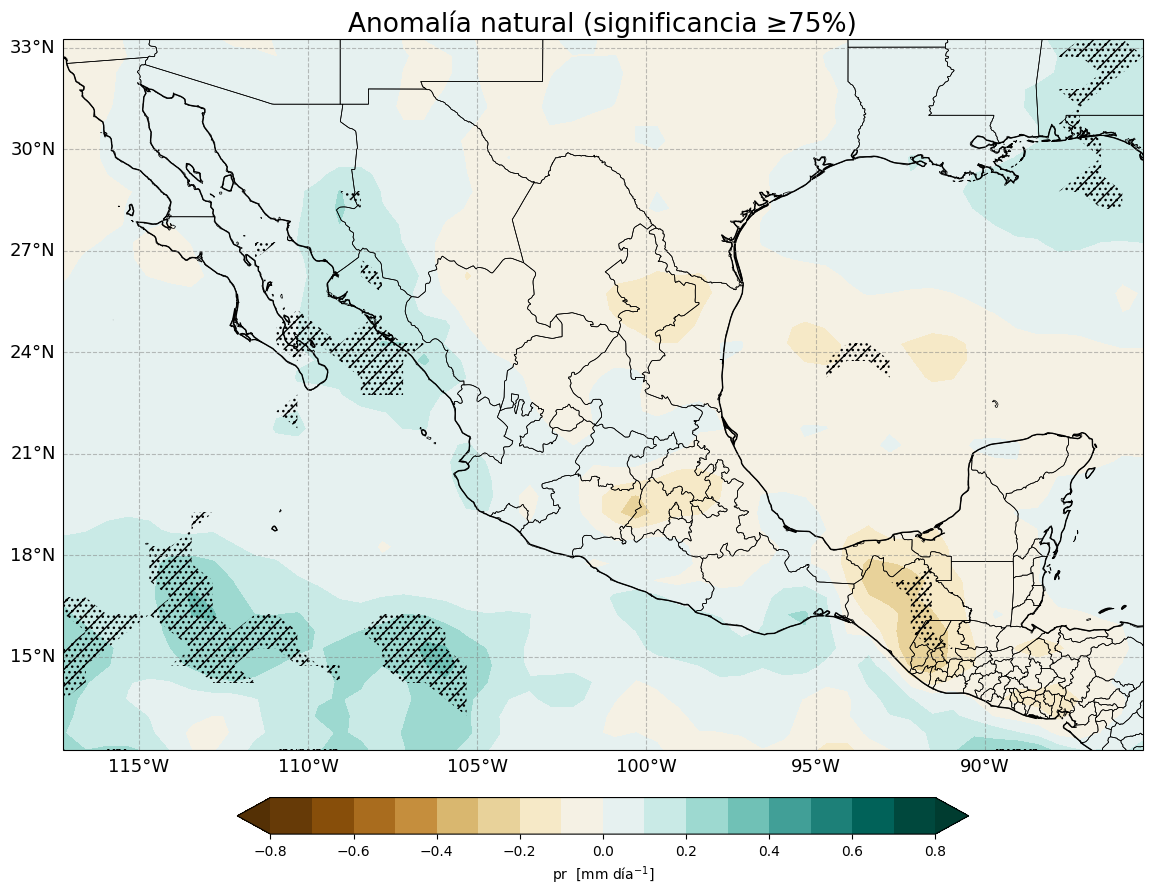

In [27]:
mapa_MC(data=anom_rolled_mean,levels=np.arange(-0.8, 0.81, 0.1),ccmap='BrBG',titulo='Anomalía natural (significancia ≥75%)',
    p_values=significativo_rolled, p_levels=[0, 1], hatches=['././.', None], lon_min=242.75, lon_max=274.68, lat_min=12.25, lat_max=33.25)

[[False False  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True False  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]
[[False False False ...  True  True  True]
 [False  True  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [False  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


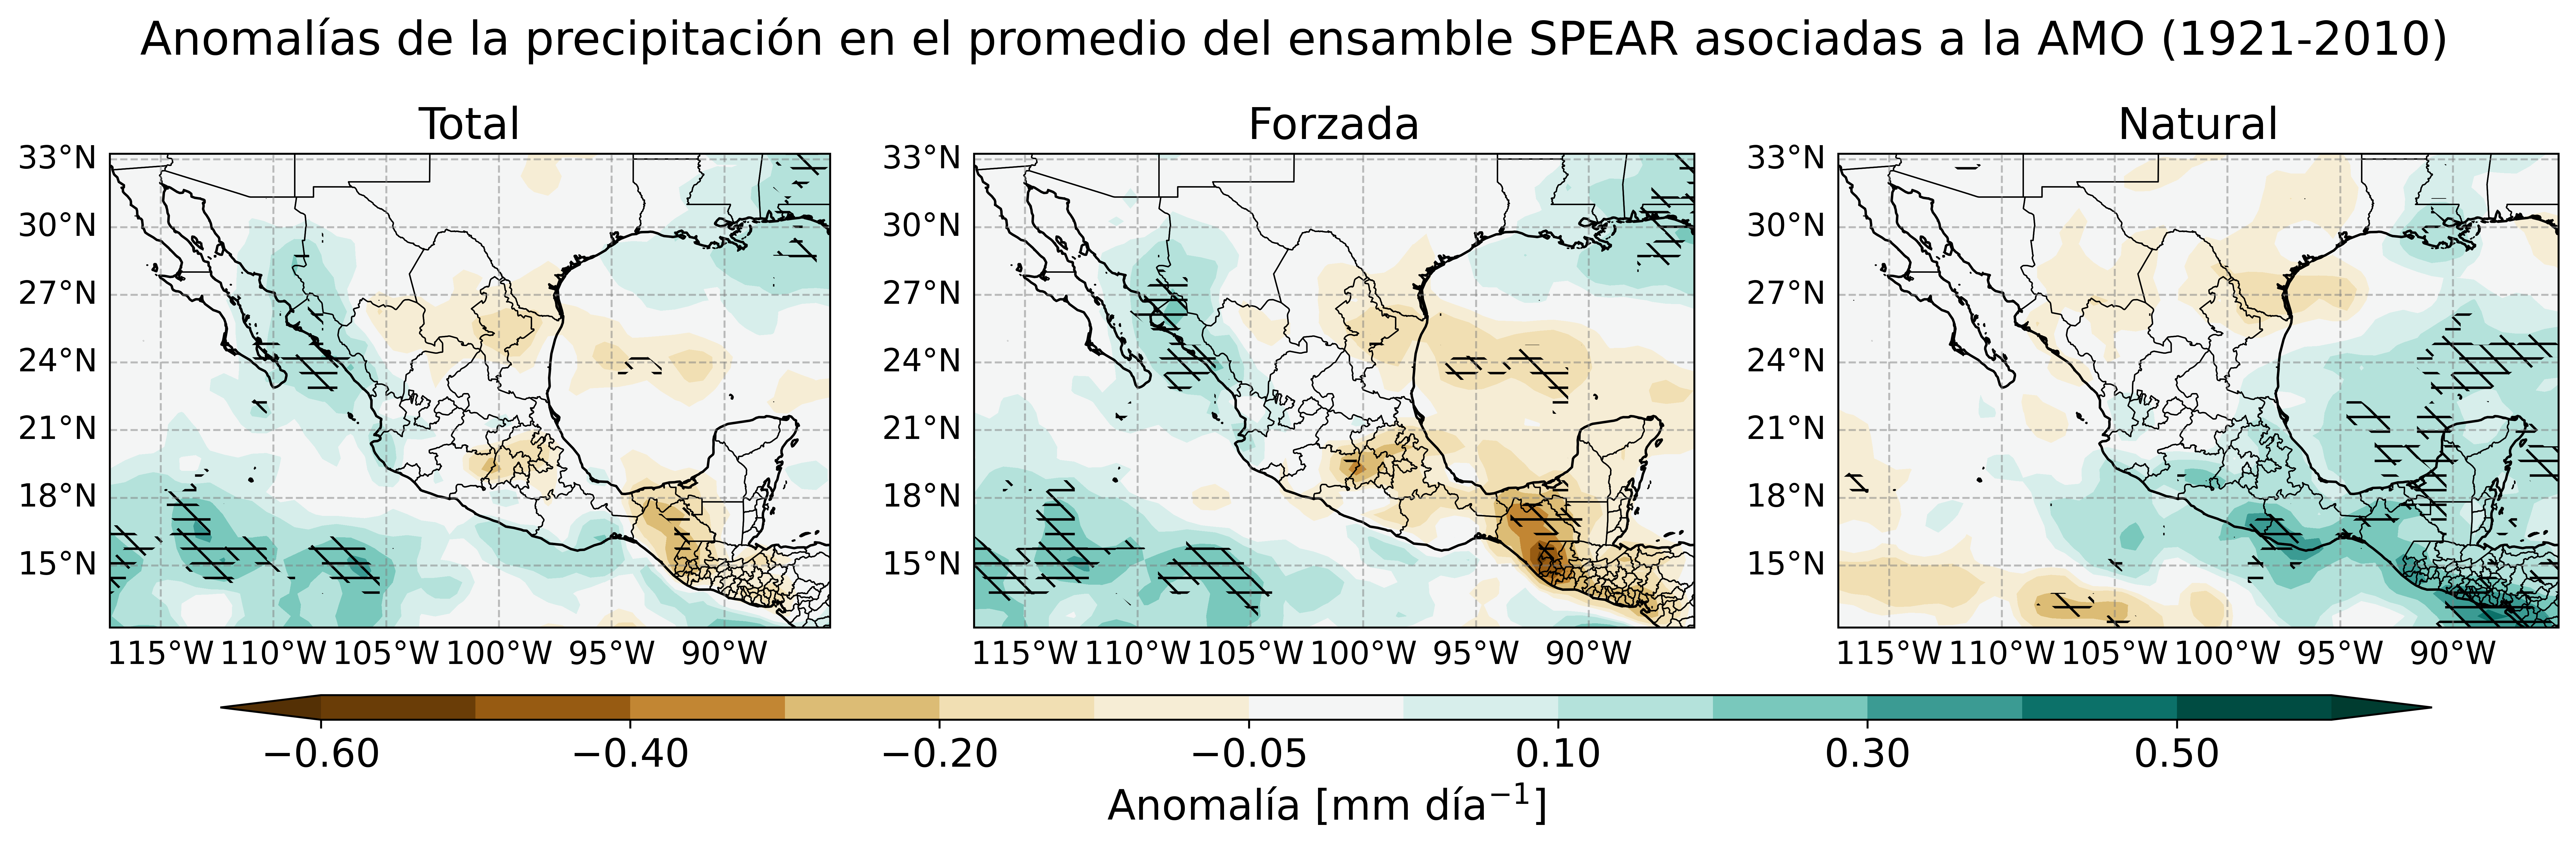

In [28]:
# Creamos un diccionario con los datos de cada componente
significancia = {"Total": significativo_rolled,"Forzada": significativo_forced,"Natural": significativo_natural}


# Creamos subplots 
fig, axs = plt.subplots(1, 3, figsize=(18, 5), dpi=600, subplot_kw={'projection': ccrs.PlateCarree()})
#panel_labels = ['a)', 'b)', 'c)']

levels = [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,0.05,0.1,0.2,0.3,0.4,0.5,0.6]#np.arange(-0.7, 0.71, 0.1)  # de mm/día

# hacemos un ciclo para graficar
for i, (titulo, anom) in enumerate(datos.items()):
    ax = axs[i]
    ax.coastlines()
    
    cs = ax.contourf(anom.lon, anom.lat, anom,levels=levels, cmap='BrBG', extend='both',transform=ccrs.PlateCarree())
    
    # hatching de significancia
    sig = significancia[titulo]
    if isinstance(sig, xr.DataArray):
        sig = sig.values  # convertir a numpy si se necesita

    # Hacer que coincida con anom si es necesario 
    if sig.shape != anom.shape:
        sig, _ = add_cyclic_point(sig, coord=anom.lon)

    # hatching donde hay significancia
    hatch_mask = np.ma.masked_where(~sig, sig)
    ax.contourf(
        anom.lon, anom.lat, ~sig,
        levels=[0, 0.05], hatches=['\-\-'], colors='none',
        transform=ccrs.PlateCarree()
    )
    print(~sig)
    # Config. del mapa
    ax.set_extent([242.75, 274.68, 12.25, 33.25], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.55)
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    gl.top_labels = gl.right_labels = False
    ax.set_title(titulo, fontsize=18)

  #  ax.text(0.97, 0.95, panel_labels[i], transform=ax.transAxes, fontsize=17, fontname='Liberation Serif', fontweight='bold', va='top', ha='right',
    #    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.27', linewidth=1))

    plt.suptitle("Anomalías de la precipitación en el promedio del ensamble SPEAR asociadas a la AMO (1921-2010)", fontsize=19, y=0.92)

# Agregando cbar
add_map_colorbar('horizontal', [0.16, 0.12, 0.7, 0.028], 'Anomalía [mm día$^{-1}$]', fig, cs)

#plt.tight_layout()
plt.show()